* Convolutional Neural Network on MNIST by Chainer

In [11]:
import datetime
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import model_selection, metrics
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [3]:
import urllib
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    from six.moves import urllib
    from scipy.io import loadmat
    import os
    print('Could not download MNIST data from mldata.org, trying alternative...')
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    mnist_path = './mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw['data'].T,
        "target": mnist_raw['label'][0],
        "COL_NAMES": ['label', 'data'],
        "DESCR": 'mldata.org dataset: mnist-original',
    }
    print('Success!')

In [4]:
mnist['data'] = mnist['data'].astype(np.float32).reshape(len(mnist['data']), 1, 28, 28) # image data
mnist['data'] /= 255
mnist['target'] = mnist['target'].astype(np.int32) # label data
mnist['data'].shape, mnist['target'].shape

((70000, 1, 28, 28), (70000,))

In [8]:
# train data size : validation data size= 8 : 2
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(mnist['data'], mnist['target'], test_size=0.2)

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((56000, 1, 28, 28), (56000,), (14000, 1, 28, 28), (14000,))

In [18]:
# モデルクラス定義

class CNN(chainer.Chain):
    
    def __init__(self):
        super(CNN, self).__init__(            
            conv1 = L.Convolution2D(None, 20, 5),
            conv2 = L.Convolution2D(20, 50, 5),
            l1 = L.Linear(800, 500),
            l2 = L.Linear(500, 500),
            l3 = L.Linear(500, 10, initialW=np.zeros((10, 500), dtype=np.float32))
        )
 
    def __call__(self, x, t=None, train=False):
        
        x = chainer.Variable(x)
        if train:
            t = chainer.Variable(t)
            
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        y = F.softmax(self.l3(h), axis=1)
        
        if train:
            loss, accuracy = F.softmax_cross_entropy(y, t), F.accuracy(y, t)
            return loss, accuracy
        else:
            return np.argmax(y.data, axis=1)
 
    def reset(self):
        
        self.zerograds() # 勾配の初期化

In [19]:
gpu = 0

model = CNN()
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

if gpu >= 0:
    
    chainer.cuda.get_device(gpu).use()
    model.to_gpu(gpu)
    
    train_x = chainer.cuda.to_gpu(train_x)
    train_y = chainer.cuda.to_gpu(train_y)

In [20]:
# train

epoch_num = 5
batch_size = 1000
N = train_x.shape[0]

st = datetime.datetime.now()
for epoch in range(epoch_num):
    
    # mini-batch
    perm = np.random.permutation(N)
    total_loss = 0
    total_accuracy = 0
    
    for i in range(0, N, batch_size):
        
        x = train_x[perm[i:i+batch_size]]
        t = train_y[perm[i:i+batch_size]]
        
        model.reset()
        loss, accuracy = model(x=x, t=t, train=True)
        loss.backward()
        loss.unchain_backward()
        total_loss += loss.data
        total_accuracy += accuracy.data
        optimizer.update()
        
    ed = datetime.datetime.now()
    print("epoch:\t{}\ttotal loss:\t{}\tmean accuracy:\t{}\ttime:\t{}".format(epoch+1, total_loss, total_accuracy/(N/batch_size), ed-st))
    st = datetime.datetime.now()

epoch:	1	total loss:	103.07084	mean accuracy:	0.6566249	time:	0:00:00.707081
epoch:	2	total loss:	94.620056	mean accuracy:	0.7714464	time:	0:00:00.673655
epoch:	3	total loss:	93.4981	mean accuracy:	0.7904821	time:	0:00:00.678233
epoch:	4	total loss:	85.87946	mean accuracy:	0.9309107	time:	0:00:00.706425
epoch:	5	total loss:	83.2471	mean accuracy:	0.9762682	time:	0:00:00.683051


In [21]:
model.to_cpu()

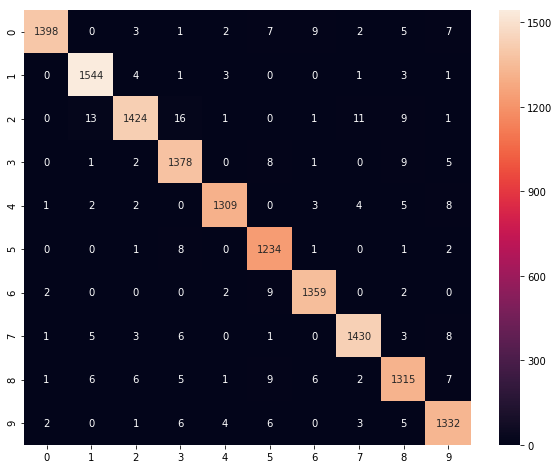

In [23]:
preds = model(valid_x, train=False)
    
cm = metrics.confusion_matrix(preds, valid_y)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

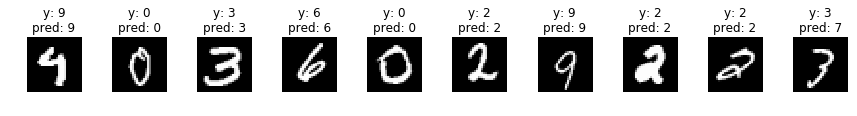

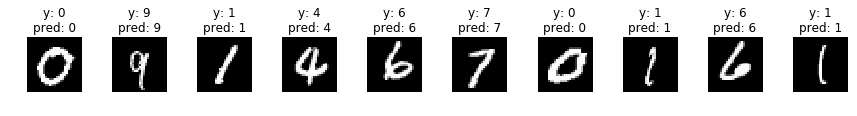

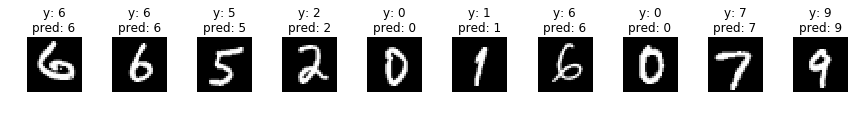

In [25]:
indices = np.random.choice(len(valid_x), 30)

for i, idx in enumerate(indices):
    
    if i%10 == 0:
        fig, axs = plt.subplots(ncols=10, figsize=(15,1))
    
    x = valid_x[idx]
    y = valid_y[idx]
    
    x_img = x.reshape(28, 28)
    x = x[np.newaxis]
    
    pred = model(x, train=False)[0]

    axs[i%10].imshow(x_img, cmap='gray')
    title = 'y: {}'.format(y) + '\n' + 'pred: {}'.format(pred)
    axs[i%10].set_title(title)
    axs[i%10].axis('off')

plt.show()

In [26]:
!python --version

Python 3.6.3


In [27]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [28]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [29]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
